In [1]:
import sqlite3
import pandas as pd
import numpy as np
from random import sample, choice, random, shuffle
from datetime import datetime, timedelta
from time import sleep
import matplotlib.pyplot as plt
import pickle
import re
from time import time
from scipy.stats import pearsonr
from scipy.signal import convolve
import urllib.request
from urllib.error import HTTPError
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib as mpl
mpl.rc('image', cmap='gray')

In [2]:
def execute_query(query, retval=False):
    #create a database connection
    conn = sqlite3.connect('videos.db')

    #create a cursor
    cur = conn.cursor()
    
    cur.execute(query)
    result = cur.fetchall()

    #close connection
    conn.commit()
    conn.close()
    
    if retval:
        return result

In [3]:
df = pd.read_csv('sigmoid_data.csv')

In [4]:
vid_ids = list(df.video_id.values)

In [5]:
formatted_vid_ids_string = ','.join(["\"%s\""%v for v in vid_ids])

## Face Features

In [6]:
face_results = execute_query('SELECT VideoID, Data FROM ThumbnailEntities WHERE VideoID IN (%s) AND EntityType = "face"'%formatted_vid_ids_string, True)

In [7]:
vid_id_to_num_faces = {vid_id: 0 for vid_id in vid_ids}
for vid_id, data in face_results:
    data_dict = eval(data)
    vid_id_to_num_faces[vid_id] += (data_dict['confidence'] > 0.5)

## Text Features

In [8]:
text_results = execute_query('SELECT VideoID, Data FROM ThumbnailEntities WHERE VideoID IN (%s) AND EntityType = "text"'%formatted_vid_ids_string, True)

In [9]:
vid_id_to_has_text = {vid_id: 0 for vid_id in vid_ids}
for vid_id, data in text_results:
    vid_id_to_has_text[vid_id] = 1

## Image Features

In [10]:
image_results = execute_query('SELECT VideoID, Data FROM ThumbnailEntities WHERE VideoID IN (%s) AND EntityType = "image"'%formatted_vid_ids_string, True)

In [11]:
vid_id_to_dom_color = {vid_id: [None, None, None, -1] for vid_id in vid_ids}
for vid_id, data in image_results:
    score = float(re.findall("'score': (\d+.\d+)", data)[0])
    if score > vid_id_to_dom_color[vid_id][3]:   
        try:
            red = float(re.findall('red: (\d+.\d+)', data)[0])
            green = float(re.findall('green: (\d+.\d+)', data)[0])
            blue = float(re.findall('blue: (\d+.\d+)', data)[0])
        except:
            red,blue,green = None, None, None
        vid_id_to_dom_color[vid_id] = [red, green, blue, score]

## Simplicity

In [31]:
thumbnail_info = execute_query('SELECT VideoID, ThumbnailURL FROM Videos WHERE VideoID IN (%s)'%formatted_vid_ids_string, True)

In [111]:
edge_kernel = np.ones((3,3)) * (-1/8)
edge_kernel[1,1] = 1

In [37]:
thresh = 0.25

vid_id_to_pct_edges = {}

for vid_id, thumbnail_url in thumbnail_info:
    try:
        urllib.request.urlretrieve(thumbnail_url, "working_thumbnail.jpg")
    except HTTPError:
        print(vid_id, thumbnail_url)
        continue
    img = plt.imread('working_thumbnail.jpg') / 255
    img = np.mean(img, axis=2)
    edge_detected = abs(convolve(img, edge_kernel, mode='same'))
    pct_edges = np.mean(edge_detected > 0.25)
    vid_id_to_pct_edges[vid_id] = pct_edges

0Efxhq-fnVQ https://i.ytimg.com/vi/0Efxhq-fnVQ/hqdefault.jpg
4xlLCbJYOHI https://i.ytimg.com/vi/4xlLCbJYOHI/hqdefault.jpg
7_Js8h709Dw https://i9.ytimg.com/vi/7_Js8h709Dw/hqdefault.jpg?sqp=CJDiuvcF&rs=AOn4CLDmXRfaDkhR68MWL0JJcHFeAOoLyA
8ps_JEW42xs https://i9.ytimg.com/vi/8ps_JEW42xs/hqdefault.jpg?sqp=CJCCkvYF&rs=AOn4CLCxZia7C1ZiRGsocpyXgYl0oOaDRQ
DkyM93Wgh_0 https://i9.ytimg.com/vi/DkyM93Wgh_0/hqdefault.jpg?sqp=CICIvvcF&rs=AOn4CLBex2uaP6DAWgzed1xnh4U0QRkgXQ
Ed6CSJbyVak https://i9.ytimg.com/vi/Ed6CSJbyVak/hqdefault.jpg?sqp=CMCr4PcF&rs=AOn4CLCdBh2q4g_YAr3_2_Ea2MCjyMUEiw
GpGq6VAUR8U https://i.ytimg.com/vi/GpGq6VAUR8U/hqdefault.jpg
HAJey9-Q8js https://i9.ytimg.com/vi/HAJey9-Q8js/hqdefault.jpg?sqp=CKDz3_cF&rs=AOn4CLAyC1IEaJXtgWMy3WxSI0s88O5ZWw
KTKAp9Q3yWg https://i9.ytimg.com/vi/KTKAp9Q3yWg/hqdefault.jpg?sqp=CJCkvvcF&rs=AOn4CLC2A6YdNV6nOSKe4SVuNuv2681u4A
NKHQiN-08S8 https://i9.ytimg.com/vi/NKHQiN-08S8/hqdefault.jpg?sqp=CLDfi_cF&rs=AOn4CLC8re1o8ty-DuXeQytHz73kfwHEQg
Yz3mQhuMACs https://i.ytim

In [163]:
data = []
for vid_id in vid_ids:
    curr_data = []
    curr_data.append(vid_id)
    curr_data.append(vid_id_to_num_faces[vid_id])
    curr_data.append(vid_id_to_has_text[vid_id])
    curr_data.append(vid_id_to_dom_color[vid_id][0])
    curr_data.append(vid_id_to_dom_color[vid_id][1])
    curr_data.append(vid_id_to_dom_color[vid_id][2])
    curr_data.append(vid_id_to_pct_edges[vid_id] if vid_id in vid_id_to_pct_edges else None)
    data.append(curr_data)

In [164]:
df_thumbnail_features = pd.DataFrame(columns=['video_id', 'num_faces', 'has_text', 'red', 'green', 'blue', 'pct_edges'], data=data)

In [165]:
df_thumbnail_features.to_csv('thumbnail_features.csv', index=False)

# Title Features

In [32]:
title_info = execute_query('SELECT VideoID, Title FROM Videos WHERE VideoID IN (%s)'%formatted_vid_ids_string, True)

In [33]:
data = []
first_person_nouns = ['i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']
personal_nouns = ['i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours', 'you', 'your', 'yours', 'he', 'she', 'him', 'her', 'his', 'hers', 'they', 'them', 'their', 'theirs']

for vid_id, title in title_info:
    curr_data = []
    curr_data.append(vid_id)
    curr_data.append(title)
    curr_data.append(len(title.split(' ')))
    curr_data.append(len(title))
    curr_data.append(int(title.replace(' ','')[-1] == '?'))
    curr_data.append(int(title.replace(' ','')[-1] == '!'))
    curr_data.append(int(len([w for w in title.lower().split(' ') if w in first_person_nouns]) > 0))
    curr_data.append(int(len([w for w in title.lower().split(' ') if w in personal_nouns]) > 0))
    data.append(curr_data)
df_title_features = pd.DataFrame(columns=['video_id', 'title', 'num_words', 'num_chars', 'ends_in_question', 'ends_in_exclamation', 'contains_first_person', 'contains_personal_noun'], data=data)

In [34]:
df_title_features.mean()

num_words                  9.333150
num_chars                 51.724574
ends_in_question           0.040132
ends_in_exclamation        0.110500
contains_first_person      0.146234
contains_personal_noun     0.246289
dtype: float64

In [35]:
df_title_features.to_csv('title_features.csv', index=False)

# Other Features

In [36]:
def str_to_duration(s):
    total_seconds = 0
    
    hours = re.findall(r'(\d+)H', s)
    if len(hours) > 0:
        total_seconds += int(hours[0]) * 3600
        
    minutes = re.findall(r'(\d+)M', s)
    if len(minutes) > 0:
        total_seconds += int(minutes[0]) * 60
        
    seconds = re.findall(r'(\d+)S', s)
    if len(seconds) > 0:
        total_seconds += int(seconds[0])
        
    return total_seconds

In [37]:
duration_info = execute_query('SELECT VideoID, Duration FROM Videos WHERE VideoID IN (%s)'%formatted_vid_ids_string, True)

In [38]:
vid_id_to_duration = {vid_id: str_to_duration(d) for vid_id, d in duration_info}

In [12]:
df_past_vids = pd.read_csv('vids_and_past_vids.csv')

In [40]:
vid_id_to_hours_since_last_vid = dict(zip(df_past_vids.video_id, df_past_vids.hours_between_last_and_curr))

In [41]:
data = []
for vid_id in vid_ids:
    data.append([vid_id, vid_id_to_duration[vid_id], vid_id_to_hours_since_last_vid[vid_id]])
df_other_features = pd.DataFrame(columns=['video_id', 'duration', 'hours_since_last_vid'], data=data)

In [42]:
df_other_features.to_csv('other_features.csv', index=False)

In [43]:
df_other_features

,video_id,duration,hours_since_last_vid
0,KrC2NqZh-9U,871,24.00
1,z87xwoms6Os,836,48.00
2,fH3JRGiR-bg,724,48.00
3,7Wf3qK6SNEw,659,24.00
4,93Q7jiDLHIY,748,48.00
...,...,...,...
1814,6RAdnCwbUrg,507,48.50
1815,C9lbKZqCdhQ,578,48.00
1816,YeYOp8NhmuA,398,47.25
1817,KUjtuQOtWdI,503,48.25


## Join all together

In [5]:
df_thumbnail_features = pd.read_csv('thumbnail_features.csv')
df_title_features = pd.read_csv('title_features.csv')
df_other_features = pd.read_csv('other_features.csv')

In [6]:
df_joined = df_thumbnail_features.merge(df_title_features, on='video_id')
df_joined = df_joined.merge(df_other_features, on='video_id')

In [7]:
len(df_joined)

1819

In [7]:
#df_joined.to_csv('all_features.csv', index=False)

NameError: name 'df_joined' is not defined

# Prob Method

In [13]:
df_joined = pd.read_csv('all_features.csv')

In [14]:
features = [f for f in df_joined.columns if f not in ['channel_id', 'video_id', 'a', 'b', 'mape', 'title']]
discrete_feaures = ['has_text', 'ends_in_question', 'ends_in_exclamation', 'contains_first_person', 'contains_personal_noun']
cts_features = [f for f in features if f not in discrete_feaures]

In [15]:
df_joined_valid = df_joined[(~np.isnan(df_joined.b))&(~np.isinf(df_joined.b))&(df_joined.mape > 0)&(df_joined.mape < 20)&(~np.isinf(df_joined.mape))]

In [16]:
channel_num_videos_condition = df_joined_valid.groupby('channel_id').video_id.count().sort_values() >= 20
valid_channels = channel_num_videos_condition[channel_num_videos_condition].index

In [17]:
df_joined_valid = df_joined_valid[df_joined_valid.channel_id.isin(valid_channels)]

In [18]:
last_vid_ids = []
for vid_id in df_joined_valid.video_id:
    sub_df = df_past_vids[df_past_vids.video_id == vid_id]
    if len(sub_df) == 0:
        last_vid_ids.append(None)
        continue
    last_vid_ids.append(sub_df.last_video_id.iloc[0])
df_joined_valid['last_video_id'] = last_vid_ids

In [19]:
numerator = np.log((1+0.9)/(1-0.9))

df_joined_valid['plateau'] = df_joined_valid.a / 2
df_joined_valid['time_90'] = numerator / df_joined_valid.b

In [20]:
metric_channel_id_to_median = df_joined_valid.groupby('channel_id').median()[['plateau', 'time_90']].to_dict()

In [21]:
i_plateau = []
i_time_90 = []

for i,row in df_joined_valid.iterrows():
    i_plateau.append(int(row.plateau > metric_channel_id_to_median['plateau'][row.channel_id]))
    i_time_90.append(int(row.time_90 > metric_channel_id_to_median['time_90'][row.channel_id]))
    
df_joined_valid['i_plateau'] = i_plateau
df_joined_valid['i_time_90'] = i_time_90

In [22]:
vid_ids_with_last = []
last_i_plateau = []
last_i_time_90 = []
for i,row in df_joined_valid.iterrows():
    if row.last_video_id in df_joined_valid.video_id.values:
        vid_ids_with_last.append(row.video_id)
        sub_df = df_joined_valid[df_joined_valid.video_id == row.last_video_id]
        last_i_plateau.append(sub_df.i_plateau.iloc[0])
        last_i_time_90.append(sub_df.i_time_90.iloc[0])
        
df_joined_valid = df_joined_valid[df_joined_valid.video_id.isin(vid_ids_with_last)].reset_index(drop=True)
df_joined_valid['i_plateau_last'] = last_i_plateau
df_joined_valid['i_time_90_last'] = last_i_time_90

In [23]:
df_joined_valid = df_joined_valid.dropna()

In [24]:
feat_to_channel_to_median_dict = df_joined_valid.groupby('channel_id').median()[cts_features].to_dict()

In [25]:
for f in cts_features:
    new_feats = []
    for idx,data in df_joined_valid[['channel_id', f]].iterrows():
        new_feats.append(int(data[f] > feat_to_channel_to_median_dict[f][data.channel_id]))
    df_joined_valid[f] = new_feats             

In [26]:
def k_l_divergence(d0,d1):
    if sum(d0) < .98 or sum(d0) > 1.02 or sum(d1) < .98 or sum(d1) > 1.02:
        print(sum(d0), sum(d1))
        print(d0)
        print(d1)
        return
    
    if 0 in d0:
        return -1
    
    kl_div = 0
    
    for idx in range(len(d1)):
        kl_div += d1[idx]*np.log(d1[idx]/d0[idx])
    return kl_div

In [27]:
def b_dist(d0,d1):
    if sum(d0) < .98 or sum(d0) > 1.02 or sum(d1) < .98 or sum(d1) > 1.02:
        print(sum(d0), sum(d1))
        print(d0)
        print(d1)
        return
    
    add = 0
    
    for idx in range(len(d1)):
        add += (d0[idx]*d1[idx])**.5
    return -np.log(add)

In [28]:
def abs_dist(d0,d1):
    if sum(d0) < .98 or sum(d0) > 1.02 or sum(d1) < .98 or sum(d1) > 1.02:
        print(sum(d0), sum(d1))
        print(d0)
        print(d1)
        return
    
    return sum([abs(p0-p1) for p0,p1 in zip(d0,d1)])

In [29]:
def make_prediction(vals, classifier):
    vals = tuple(vals)
    if classifier[all_keys.index(vals)] > 1:
        return 1
    elif classifier[all_keys.index(vals)] < 1:
        return 0
    return None

In [30]:
all_keys = [(0,0,0), (0,0,1), (0,1,0), (1,0,0), (1,0,1), (1,1,0), (0,1,1), (1,1,1)]

def run_cross_validation(k, dist_metric_name, df_joined_valid, metric, feature_pair=None):

    #shuffle data and split into sets
    df_joined_valid = df_joined_valid.sample(frac=1)
    test_len = len(df_joined_valid) // k
    data_sets = [df_joined_valid.iloc[i:i+test_len] for i in range(k)]

    #store the accuracy values and features
    metric_vals = {i: [[], [], []] for i in range(k)}
    
    feature_pair_classifiers = []

    #for each test set...
    for i in range(k):
        #get the test set
        test_set = data_sets[i]
        
        #get the train set
        train_set = pd.concat([data_sets[j] for j in range(k) if j!=i])

        #this will store the informatiion about each feature pair
        dist_feats = [[], [], []]

        #loop over all feature pairs
        for idx,F1 in enumerate(features):
            for F2 in features[idx+1:]:
                
                #subset the train set
                curr_train_set = train_set[['i_%s'%metric, 'i_%s_last'%metric, F1, F2]]

                metric_0_df = curr_train_set[curr_train_set['i_%s'%metric] == 0][['i_%s_last'%metric, F1, F2]]
                metric_0_df['n'] = 1
                metric_1_df = curr_train_set[curr_train_set['i_%s'%metric] == 1][['i_%s_last'%metric, F1, F2]]
                metric_1_df['n'] = 1

                gb_0_df = metric_0_df.groupby(['i_%s_last'%metric, F1, F2]).count() / len(metric_0_df)
                gb_1_df = metric_1_df.groupby(['i_%s_last'%metric, F1, F2]).count() / len(metric_1_df)

                probs_0 = dict(zip(gb_0_df.index, gb_0_df.n.values))
                probs_1 = dict(zip(gb_1_df.index, gb_1_df.n.values))

                p0 = np.array([probs_0[k] if k in probs_0 else 0 for k in all_keys])
                p1 = np.array([probs_1[k] if k in probs_1 else 0 for k in all_keys])
                classifier = p1/p0

                distr_dist_vals = {'kl': k_l_divergence(p0, p1), 'b': b_dist(p0, p1), 'abs': abs_dist(p0, p1)}
                distr_dist_val = distr_dist_vals[dist_metric_name]

                dist_feats[0].append(distr_dist_val)
                dist_feats[1].append((F1,F2))
                dist_feats[2].append(classifier)
                
                if [F1,F2] == feature_pair or [F2,F1] == feature_pair:
                    feature_pair_classifiers.append(classifier)
                    
        if feature_pair == None:

            for j in range(len(dist_feats[0])):
                data = [l[j] for l in dist_feats]
                val = data[0]
                feats = data[1]
                classifier = data[2]

                #further isolate test set columns
                curr_test_set = test_set[['i_%s'%metric, 'i_%s_last'%metric, *feats]]

                predictions = curr_test_set.apply(lambda row: make_prediction([row['i_%s_last'%metric], row[feats[0]], row[feats[1]]], classifier), 1)
                actual_vals = curr_test_set['i_%s'%metric]

                acc = np.mean([pred==true for pred,true in zip(predictions,actual_vals) if pred != None])
                metric_vals[i][0].append(acc)
                metric_vals[i][1].append(feats)
                metric_vals[i][2].append(classifier)
                
    if feature_pair != None:
        return feature_pair_classifiers
    
    return metric_vals

In [334]:
n = 100

metric = 'time_90'

best_feat_pairs = []
avg_accs = []

for i in range(n):
    print('%s/%s'%(i+1,n))
    metric_vals = run_cross_validation(10, 'abs', df_joined_valid, metric)
    
    best_feat_mask = [np.where(np.array(l[0]) > np.max(l[0])-0.01)[0] for l in metric_vals.values()]
    avg_acc = np.mean([np.mean(np.array(l[0])[best_feat_mask[j]]) for j,l in enumerate(metric_vals.values())])
    avg_accs.append(avg_acc)
    print(avg_acc)
    
    best_feats = [np.array(l[1])[best_feat_mask[j]] for j,l in enumerate(metric_vals.values())]
    best_feat_pairs.extend([list(pair) for arr in best_feats for pair in arr])

1/100


C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


0.6827831715210355
2/100
0.6671521035598706
3/100
0.6530744336569579
4/100
0.6300774387424873
5/100
0.6650485436893204
6/100
0.6854368932038836
7/100
0.6457042687625212
8/100
0.635953400777787
9/100
0.6689945572227126
10/100
0.6441323778702419
11/100
0.6627022653721684
12/100
0.7058252427184465
13/100
0.647621359223301
14/100
0.6902912621359224
15/100
0.6606796116504855
16/100
0.6810679611650485
17/100
0.6352450300508554
18/100
0.6549676375404531
19/100
0.691747572815534
20/100
0.6685275080906149
21/100
0.6539967637540454
22/100
0.6474919093851133
23/100
0.6254018112099208
24/100
0.6396440129449837
25/100
0.6800970873786408
26/100
0.6757281553398059
27/100
0.670873786407767
28/100
0.6659558483587609
29/100
0.6470064724919095
30/100
0.626609647095084
31/100
0.6412532747726922
32/100
0.6680582524271845
33/100
0.6625439204808137
34/100
0.6571197411003237
35/100
0.6674252581291417
36/100
0.6496763754045307
37/100
0.6572815533980583
38/100
0.6387594390507013
39/100
0.6590614886731393
40/100

In [335]:
pickle.dump([avg_accs, best_feat_pairs], open("abs_dist_data_time_90.p", "wb"))

In [336]:
avg_accs_plateau, best_feat_pairs_plateau = pickle.load(open("abs_dist_data_plateau.p", "rb" ))
avg_accs_time_90, best_feat_pairs_time_90 = pickle.load(open("abs_dist_data_time_90.p", "rb" ))

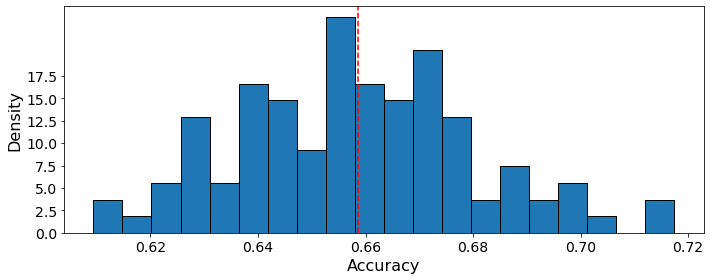

In [337]:
plt.figure(figsize=(10,4))
plt.hist(avg_accs_plateau, bins=20, edgecolor='k', density=True)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Density', fontsize=16)

plt.xticks(np.arange(0.62,.74,.02), fontsize=14)
plt.yticks(np.arange(0,20,2.5), fontsize=14)

plt.axvline(np.mean(avg_accs_plateau), linestyle='--', color='r')
plt.tight_layout()
plt.savefig('acc_plateau.png')

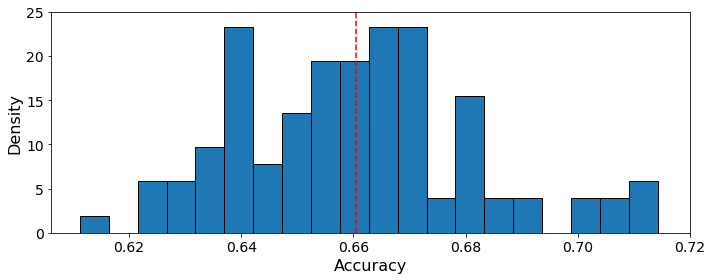

In [338]:
plt.figure(figsize=(10,4))
plt.hist(avg_accs_time_90, bins=20, edgecolor='k', density=True)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Density', fontsize=16)

plt.xticks(np.arange(0.62,.74,.02), fontsize=14)
plt.yticks(np.arange(0,30,5), fontsize=14)

plt.axvline(np.mean(avg_accs_time_90), linestyle='--', color='r')
plt.tight_layout()
plt.savefig('acc_time_90.png')

In [339]:
d_pairs = {}
for pair in best_feat_pairs_plateau:
    if tuple(pair) in d_pairs:
        d_pairs[tuple(pair)] += 1 / len(best_feat_pairs)
    else:
        d_pairs[tuple(pair)] = 1 / len(best_feat_pairs)
        
sorted(d_pairs.items(), key=lambda x: -x[1])[:5]

[(('green', 'num_chars'), 0.025027502750275044),
 (('red', 'pct_edges'), 0.02392739273927394),
 (('blue', 'duration'), 0.02310231023102311),
 (('green', 'duration'), 0.02117711771177118),
 (('has_text', 'duration'), 0.020627062706270627)]

In [340]:
d_pairs = {}
for pair in best_feat_pairs_time_90:
    if tuple(pair) in d_pairs:
        d_pairs[tuple(pair)] += 1 / len(best_feat_pairs)
    else:
        d_pairs[tuple(pair)] = 1 / len(best_feat_pairs)
        
sorted(d_pairs.items(), key=lambda x: -x[1])[:5]

[(('red', 'duration'), 0.036028602860286085),
 (('red', 'blue'), 0.030528052805280564),
 (('green', 'hours_since_last_vid'), 0.028877887788778908),
 (('red', 'num_chars'), 0.027227722772277252),
 (('num_words', 'duration'), 0.026127612761276148)]

In [353]:
metric = 'plateau'
plateau_feats = ['green', 'num_chars']

feature_pair_classifiers = run_cross_validation(10, 'abs', df_joined_valid, metric, plateau_feats)
avg_feat_clf_plateau = np.mean(feature_pair_classifiers, axis=0)

code_to_score_plateau = {'past_plateau=%s, %s=%s, %s=%s'%(k[0], plateau_feats[0], k[1], plateau_feats[1], k[2]):v for k,v in zip(all_keys, avg_feat_clf_plateau)}

C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


In [354]:
metric = 'time_90'
time_90_feats = ['red', 'duration']

feature_pair_classifiers = run_cross_validation(10, 'abs', df_joined_valid, metric, time_90_feats)
avg_feat_clf_time_90 = np.mean(feature_pair_classifiers, axis=0)

code_to_score_time_90 = {'past_time_90=%s, %s=%s, %s=%s'%(k[0], time_90_feats[0], k[1], time_90_feats[1], k[2]):v for k,v in zip(all_keys, avg_feat_clf_time_90)}

C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


In [362]:
sorted(code_to_score_time_90.items(), key=lambda x: x[1])

[('past_time_90=0, red=1, duration=1', 0.3474955745720515),
 ('past_time_90=1, red=0, duration=1', 0.5774455896448435),
 ('past_time_90=0, red=0, duration=1', 0.6961545745375017),
 ('past_time_90=0, red=0, duration=0', 1.1548903892043183),
 ('past_time_90=1, red=1, duration=1', 1.2703234600612252),
 ('past_time_90=1, red=1, duration=0', 1.6879733921282292),
 ('past_time_90=0, red=1, duration=0', 2.078668633799697),
 ('past_time_90=1, red=0, duration=0', 2.695601832686677)]

In [363]:
sorted(code_to_score_plateau.items(), key=lambda x: -x[1])

[('past_plateau=1, green=1, num_chars=0', 1.7249114371708778),
 ('past_plateau=0, green=1, num_chars=1', 1.4028648271567767),
 ('past_plateau=1, green=1, num_chars=1', 1.247811175994934),
 ('past_plateau=0, green=0, num_chars=1', 1.2476432860916935),
 ('past_plateau=1, green=0, num_chars=1', 1.0738806246009847),
 ('past_plateau=0, green=0, num_chars=0', 0.7498003953200255),
 ('past_plateau=1, green=0, num_chars=0', 0.691716548797532),
 ('past_plateau=0, green=1, num_chars=0', 0.5627254800500961)]

# Some additional graphs for report

In [65]:
data = execute_query('SELECT Timestamp, Views, Likes, Dislikes, Comments FROM VideoStats WHERE VideoID = "9sn033Kj1zE" ORDER BY Timestamp ASC', True)

In [66]:
ts = [datetime.strptime(item[0][:13], '%Y-%m-%d %H') for item in data]
views = [item[1] for item in data]
likes = [item[2] for item in data]
dislikes = [item[3] for item in data]
comments = [item[4] for item in data]

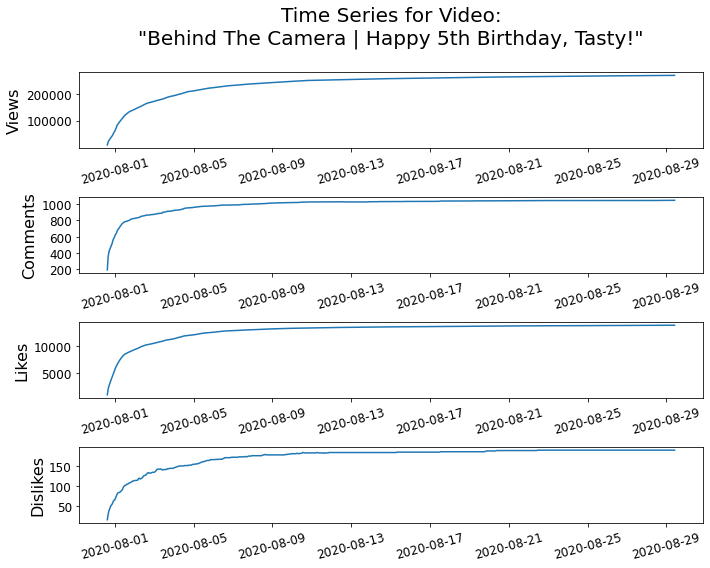

In [67]:
plt.figure(figsize=(10,8))

plt.subplot(4,1,1)
plt.plot(ts, views)
plt.xticks([datetime(2020,8,i) for i in range(1,30,4)], fontsize=12, rotation=15)
plt.yticks(np.arange(100000,300000,100000), fontsize=12)
plt.ylabel('Views', fontsize=16)
plt.title('Time Series for Video:\n"Behind The Camera | Happy 5th Birthday, Tasty!"\n', fontsize=20)

plt.subplot(4,1,2)
plt.plot(ts, comments)
plt.xticks([datetime(2020,8,i) for i in range(1,30,4)], fontsize=12, rotation=15)
plt.yticks(np.arange(200,1200,200), fontsize=12)
plt.ylabel('Comments', fontsize=16)

plt.subplot(4,1,3)
plt.plot(ts, likes)
plt.xticks([datetime(2020,8,i) for i in range(1,30,4)], fontsize=12, rotation=15)
plt.yticks(np.arange(5000,15000,5000), fontsize=12)
plt.ylabel('Likes', fontsize=16)

plt.subplot(4,1,4)
plt.plot(ts, dislikes)
plt.xticks([datetime(2020,8,i) for i in range(1,30,4)], fontsize=12, rotation=15)
plt.yticks(np.arange(50,200,50), fontsize=12)
plt.ylabel('Dislikes', fontsize=16)

plt.tight_layout()

plt.savefig('example_time_series.png')